In [22]:
from os import listdir
from os.path import join
import os.path

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import random

import cv2
import matplotlib.pyplot as plt

In [23]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 4, 1) # input, output, kernel_size, stride
        self.conv2 = nn.Conv2d(20, 50, 4, 1)
        self.fc1 = nn.Linear(9*9*50, 500)
        self.fc2 = nn.Linear(500, 82)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 9*9*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [25]:
data_path = '../data/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cuda


In [26]:
model = Net()
# model = torch.load('../model/bestModel.pth', map_location=device)
model.load_state_dict(torch.load('../model/test.pth', map_location=device))
model.to(device)
model.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=4050, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=82, bias=True)
)

In [63]:
trans = transforms.Compose([
    transforms.Resize((45,45)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    ])
trainset = torchvision.datasets.ImageFolder(root = data_path + 'extracted_images',
                                            transform = trans)
classes = trainset.classes

print(trainset.classes)
print(len(trainset.targets))


['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '[', ']', 'alpha', 'ascii_124', 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']
375974


In [28]:
from PIL import Image

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = trans(image).float()
    # image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

(45, 45)


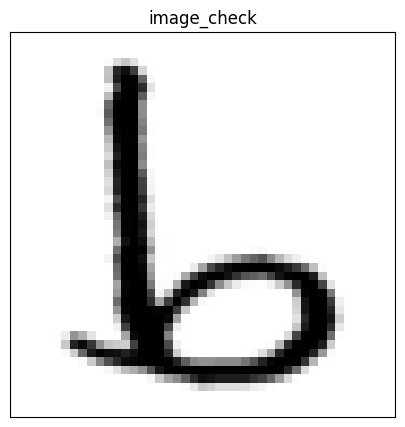

In [71]:
im_path = "../data/output/2.jpg"

img = image_loader(im_path)
image_check = torch.squeeze(img[0])
image_check = image_check.cpu().numpy()
print(image_check.shape)

plt_imshow('image_check', image_check)

In [72]:
import cv2

pred = model(img)
probs = torch.nn.functional.softmax(pred, dim=1)
conf, classes = torch.max(probs, 1)

print(conf.item())
print(classes.item())

print(f'predict: {trainset.classes[classes.item()]}')

0.9348897933959961
32
predict: b
